In [19]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

## Useful functions

In [30]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()
    
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
        get_feature_importance(model, X.columns, n_features=25)
    return model, score

## Reading and preparation

In [39]:
training = pd.read_csv("final_training.csv", delimiter=",", decimal=".")
test = pd.read_csv("test.csv", delimiter=",", decimal=".")

In [7]:
training.Ano

0         2018.0
1         2018.0
2         2018.0
3         2018.0
4         2018.0
           ...  
764623    2018.0
764624    2018.0
764625    2018.0
764626    2018.0
764627    2018.0
Name: Ano, Length: 764628, dtype: float64

In [8]:
test

,Unnamed: 0,Id_Cliente,Ano,Curso,Asignatura,TipoMaterial,Lengua,TipoSoporte,Clase,ValorClase,art_id,GrupoEditorialPrevio,Latitud,Longitud,ComunidadAutonoma,Titularidad
0,0,113956,2019,33,48,3,13,1,150.0,22.5150,11395633483131,10.0,42.852859,-2.668525,7,1
1,1,113956,2019,33,65,1,26,1,90.0,22.1760,11395633651261,90.0,42.852859,-2.668525,7,1
2,2,113956,2019,32,8,1,26,2,96.0,12.8640,1139563281262,3.0,42.852859,-2.668525,7,1
3,3,113956,2019,32,60,1,26,2,68.0,9.1188,11395632601262,1.0,42.852859,-2.668525,7,1
4,4,113956,2019,32,73,1,13,2,53.0,7.1020,11395632731132,90.0,42.852859,-2.668525,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617855,617855,212536,2019,36,48,1,13,1,99.0,46.7181,21253636481131,4.0,41.384132,2.046094,1,1
617856,617856,212536,2019,36,42,1,13,1,10.0,3.5420,21253636421131,2.0,41.384132,2.046094,1,1
617857,617857,212536,2019,36,8,1,10,1,40.0,14.1360,2125363681101,16.0,41.384132,2.046094,1,1
617858,617858,212536,2019,37,48,2,13,1,80.0,8.2720,21253637482131,4.0,41.384132,2.046094,1,1


In [34]:
def unit_price(dataframe):
    unit_price = []
    unit_price = dataframe.ValorClase/dataframe.Clase
    unit_price = pd.DataFrame(unit_price, columns = ['unit_price'])
    dataframe = pd.concat([dataframe.reset_index(drop=True), unit_price.reset_index(drop=True)], axis=1)
    return dataframe

In [35]:
training = unit_price(training)

In [36]:
training

,Id_Cliente,Curso,Asignatura,TipoMaterial,GrupoEditorialPrevio,Lengua,TipoSoporte,...,Clase,ValorClase,Latitud,Longitud,ComunidadAutonoma,Titularidad,unit_price
0,113958,27,65,3,31.0,26,1,...,26.0,114.40,42.853774,-2.391622,7,2,4.40
1,113958,27,53,2,31.0,26,1,...,26.0,366.08,42.853774,-2.391622,7,2,14.08
2,113958,24,79,1,90.0,26,1,...,7.0,90.37,42.853774,-2.391622,7,2,12.91
3,113958,26,53,3,31.0,26,1,...,54.0,0.00,42.853774,-2.391622,7,2,0.00
4,113958,28,48,1,90.0,13,1,...,18.0,347.58,42.853774,-2.391622,7,2,19.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764623,211817,23,63,1,5.0,13,1,...,60.0,1953.60,40.029670,-3.600509,5,2,32.56
764624,211817,23,48,1,34.0,13,1,...,20.0,364.20,40.029670,-3.600509,5,2,18.21
764625,211817,23,51,2,6.0,13,1,...,20.0,406.20,40.029670,-3.600509,5,2,20.31
764626,211817,24,51,2,6.0,13,1,...,20.0,388.80,40.029670,-3.600509,5,2,19.44


In [9]:
training = training.drop(['Unnamed: 0'],axis=1)
training = training.drop(['Ano'],axis=1)
training = training.drop(['GrupoEditorialActual'], axis = 1)
training = training.drop(['art_id'], axis = 1)
test = test.drop(['Unnamed: 0'],axis=1)
test = test.drop(['Ano'],axis=1)
test = test.drop(['art_id'],axis=1)

In [10]:
pd.options.display.max_columns = training.shape[1] # It prints the info in all the columns

training.describe()

,Id_Cliente,Curso,Asignatura,TipoMaterial,GrupoEditorialPrevio,Lengua,TipoSoporte,Target,Clase,ValorClase,Latitud,Longitud,ComunidadAutonoma,Titularidad
count,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000,764628.000000
mean,153829.429379,30.353170,67.919871,1.267135,33.004016,13.663486,1.023880,0.036606,44.966939,975.758634,39.633868,-2.182592,3.098355,2.450310
std,27145.744317,3.757106,57.337341,0.656809,38.788173,3.731584,0.152674,0.187793,37.085171,943.063562,3.866904,4.900557,2.016503,0.795442
min,113956.000000,20.000000,1.000000,1.000000,1.000000,10.000000,1.000000,0.000000,0.000000,0.000000,27.642512,-18.008161,1.000000,1.000000
25%,132119.000000,27.000000,48.000000,1.000000,3.000000,13.000000,1.000000,0.000000,21.000000,379.800000,39.465039,-3.655527,1.000000,2.000000
50%,163111.000000,30.000000,54.000000,1.000000,8.000000,13.000000,1.000000,0.000000,36.000000,717.860000,40.453714,-0.685345,2.000000,3.000000
75%,172936.000000,34.000000,65.000000,1.000000,90.000000,13.000000,1.000000,0.000000,57.000000,1304.920000,41.549957,1.212592,5.000000,3.000000
max,211817.000000,37.000000,280.000000,4.000000,90.000000,26.000000,2.000000,1.000000,1540.000000,34617.440000,43.424796,3.280878,7.000000,3.000000


## Data cleaning

### Dummy re-encoding

In [11]:
training.dtypes

Id_Cliente                int64
Curso                     int64
Asignatura                int64
TipoMaterial              int64
GrupoEditorialPrevio    float64
Lengua                    int64
TipoSoporte               int64
Target                  float64
Clase                   float64
ValorClase              float64
Latitud                 float64
Longitud                float64
ComunidadAutonoma         int64
Titularidad               int64
dtype: object

In [ ]:
# check data types
# if object -> as category
categorical_columns = ['Curso', 'Asignatura','TipoMaterial', 'Lengua', 'ComunidadAutonoma', 'Titularidad', 'GrupoEditorialPrevio', 'Id_Cliente','TipoSoporte']

training[categorical_columns] = training[categorical_columns].astype("category")
training.dtypes

In [13]:
test[categorical_columns] = test[categorical_columns].astype("category")
test.dtypes

KeyError: "['Target'] not in index"

## Baseline model

In [15]:
from sklearn.model_selection import train_test_split

X = training.drop(['Target'],axis=1)
y = training['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
baseline_model, score = train_model(X, y, linear_model.LogisticRegression(max_iter=10000, penalty='none', solver = 'lbfgs'))

In [ ]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', score]
results_df

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, max_depth=10)
rf_model = rf.fit(X_train,y_train)
predictions = rf_model.predict(X_test)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,predictions)))
confusion_matrix(y_test, predictions)

NameError: name 'X_train' is not defined

In [22]:
from sklearn.metrics import classification_report
model = RandomForestClassifier(random_state= 101).fit(X_train,y_train)
predictionforest = model.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc1 = accuracy_score(y_test,predictionforest)

KeyboardInterrupt: 

Accuracy = 0.8890


AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

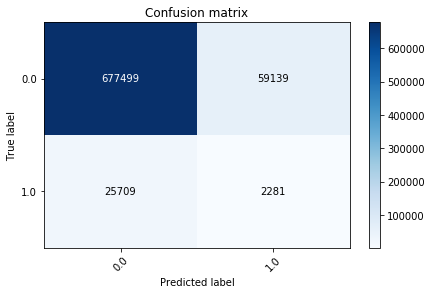

In [23]:
rf, score = train_model(X, y, RandomForestClassifier(random_state= 101))

In [ ]:
acc1 = accuracy_score(y_test,predictionforest)

## Outliers

In [27]:
numerical_cols = training.columns[training.dtypes!='category'].tolist()

In [28]:
Q1 = training[numerical_cols].quantile(0.25)
Q3 = training[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

In [29]:
((training[numerical_cols] < (Q1 - 1.5 * IQR)) | (training[numerical_cols] > (Q3 + 1.5 * IQR))).sum()

Clase         40448
ValorClase    38659
Latitud       71285
Longitud      71285
dtype: int64

Analyzing outliers of column: Clase
8492 outliers removed


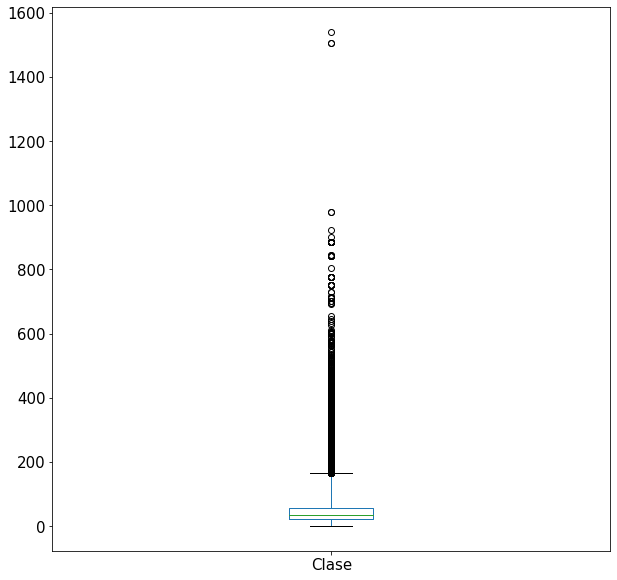

Analyzing outliers of column: ValorClase
5965 outliers removed


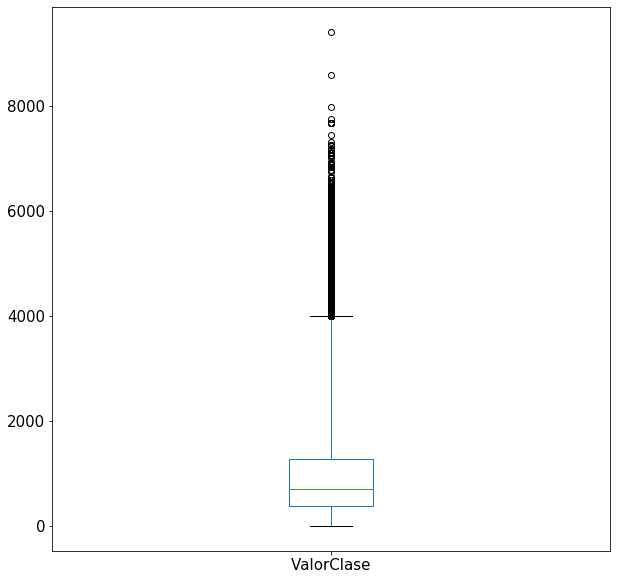

Analyzing outliers of column: Latitud
70340 outliers removed


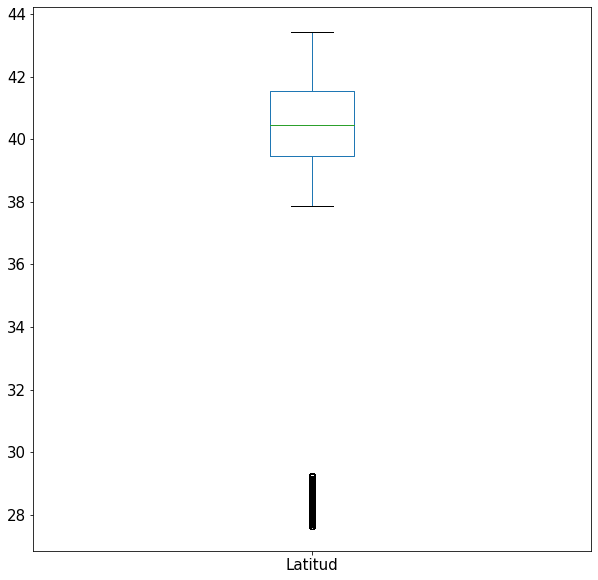

Analyzing outliers of column: Longitud
0 outliers removed


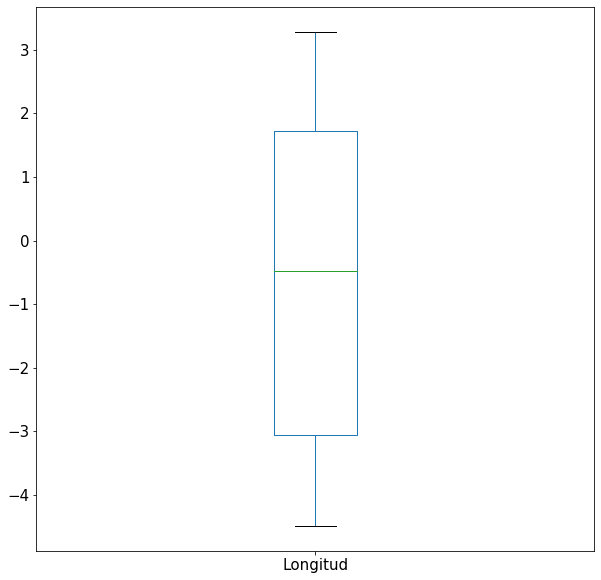

In [31]:
def remove_outlier(df_in, col_name, coef):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-coef*iqr
    fence_high = q3+coef*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

outlier_free_dataset = training # Only the training data

for (columnName, _) in outlier_free_dataset.iteritems():
    if columnName in numerical_cols: # IS numeric
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        outlier_free_dataset.boxplot([columnName], grid=False, fontsize=15, whis=3)
        outlier_free_dataset = remove_outlier(outlier_free_dataset,columnName, 3)
        plt.show()

### Baseline without outliers

In [ ]:
X = outlier_free_dataset.drop([''],axis=1)
y = outlier_free_dataset['']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
outlier_free_model, score = train_model(X, y, linear_model.LogisticRegression(max_iter=10000, penalty='none'))

In [ ]:
results_df.loc[len(results_df)] = ['LR without outliers', score]
results_df

## Correlations

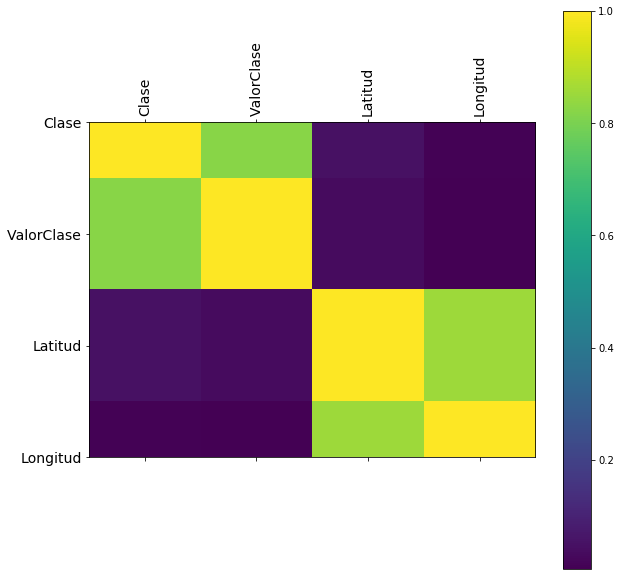

In [32]:
plt.figure(figsize=(10, 10))
plt.matshow(X[numerical_cols].corr(), fignum=1)
plt.xticks(range(X[numerical_cols].shape[1]), numerical_cols, fontsize=14, rotation=90)
plt.yticks(range(X[numerical_cols].shape[1]), numerical_cols, fontsize=14)
plt.colorbar()
plt.show()

### Removing highly correlated features

## Feature engineering

### Feature creation

In [ ]:
# create the feature
# test the model with the new feature

### Barplots insights

In [40]:
X_test = test.drop(columns=(['art_id']))

In [41]:
X_test

,Unnamed: 0,Id_Cliente,Ano,Curso,Asignatura,TipoMaterial,Lengua,...,Clase,ValorClase,GrupoEditorialPrevio,Latitud,Longitud,ComunidadAutonoma,Titularidad
0,0,113956,2019,33,48,3,13,...,150.0,22.5150,10.0,42.852859,-2.668525,7,1
1,1,113956,2019,33,65,1,26,...,90.0,22.1760,90.0,42.852859,-2.668525,7,1
2,2,113956,2019,32,8,1,26,...,96.0,12.8640,3.0,42.852859,-2.668525,7,1
3,3,113956,2019,32,60,1,26,...,68.0,9.1188,1.0,42.852859,-2.668525,7,1
4,4,113956,2019,32,73,1,13,...,53.0,7.1020,90.0,42.852859,-2.668525,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617855,617855,212536,2019,36,48,1,13,...,99.0,46.7181,4.0,41.384132,2.046094,1,1
617856,617856,212536,2019,36,42,1,13,...,10.0,3.5420,2.0,41.384132,2.046094,1,1
617857,617857,212536,2019,36,8,1,10,...,40.0,14.1360,16.0,41.384132,2.046094,1,1
617858,617858,212536,2019,37,48,2,13,...,80.0,8.2720,4.0,41.384132,2.046094,1,1
